In [1]:
import pandas as pd
import numpy as np
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

#from google.colab import files
import io

train_df = pd.read_csv('data/train_df.csv')
print(train_df.head)

test_df = pd.read_csv('data/test_df.csv')
print(test_df.head)


<bound method NDFrame.head of       tBodyAccmeanX  tBodyAccmeanY  tBodyAccmeanZ  tBodyAccstdX  tBodyAccstdY  \
0          0.278419      -0.016411      -0.123520     -0.998245     -0.975300   
1          0.279653      -0.019467      -0.113462     -0.995380     -0.967187   
2          0.279174      -0.026201      -0.123283     -0.996091     -0.983403   
3          0.276629      -0.016570      -0.115362     -0.998139     -0.980817   
4          0.277199      -0.010098      -0.105137     -0.997335     -0.990487   
...             ...            ...            ...           ...           ...   
7346       0.299665      -0.057193      -0.181233     -0.195387      0.039905   
7347       0.273853      -0.007749      -0.147468     -0.235309      0.004816   
7348       0.273387      -0.017011      -0.045022     -0.218218     -0.103822   
7349       0.289654      -0.018843      -0.158281     -0.219139     -0.111412   
7350       0.351503      -0.012423      -0.203867     -0.269270     -0.087212  

In [2]:
print(train_df.drop(['activity_name'], axis = 1))

train_df_2 = train_df.drop(['activity_name'], axis = 1)

train_arr = train_df_2.to_numpy()

x_train = train_arr[:, 0:561]
print(x_train.shape)

print(train_arr[:, 562])
y_train = train_arr[:, 562]
print(y_train.shape)

#process test data
print(test_df.head)
test_df_2 = test_df.drop(['activity_name'], axis = 1)
print(test_df_2)

test_arr = test_df_2.to_numpy()

x_test = test_arr[:, 0:561]
print(x_test.shape)

print(test_arr[:, 562])
y_test = test_arr[:, 562]
print(y_test.shape)

      tBodyAccmeanX  tBodyAccmeanY  tBodyAccmeanZ  tBodyAccstdX  tBodyAccstdY  \
0          0.278419      -0.016411      -0.123520     -0.998245     -0.975300   
1          0.279653      -0.019467      -0.113462     -0.995380     -0.967187   
2          0.279174      -0.026201      -0.123283     -0.996091     -0.983403   
3          0.276629      -0.016570      -0.115362     -0.998139     -0.980817   
4          0.277199      -0.010098      -0.105137     -0.997335     -0.990487   
...             ...            ...            ...           ...           ...   
7346       0.299665      -0.057193      -0.181233     -0.195387      0.039905   
7347       0.273853      -0.007749      -0.147468     -0.235309      0.004816   
7348       0.273387      -0.017011      -0.045022     -0.218218     -0.103822   
7349       0.289654      -0.018843      -0.158281     -0.219139     -0.111412   
7350       0.351503      -0.012423      -0.203867     -0.269270     -0.087212   

      tBodyAccstdZ  tBodyAc

In [3]:
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

print("Machine learning libraries loaded")
print (x_train.shape)
print (x_test.shape)

Machine learning libraries loaded
(7351, 561)
(2946, 561)


In [4]:
def predict_y(x_train, x_test, y_train, y_test):
    #Use the transformed data to make predictions 
    from sklearn.svm import SVC
    from sklearn import metrics

    svc = SVC(C=10, gamma= 0.01)
    #train model
    svc.fit(x_train, y_train)
    #test
    y_pred = svc.predict(x_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    #var = metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average')
    print(acc)
    #print(metrics.confusion_matrix(y_test, y_pred))
    #print(metrics.classification_report(y_test, y_pred))

    return acc
print("Function for prediction")

def model_train_test(data, nodes, optimizer):
    x_train, x_test, y_train, y_test = data
    input_shape = x_train.shape[1]
    inputs = Input(shape=(input_shape))

    optimizer_acc = []
    optimizer_var = []
    for o in range(len(optimizer)):
        if optimizer[o] == "Adam":
            opt = tf.keras.optimizers.Adam()
        if optimizer[o] == "SGD":
            opt = tf.keras.optimizers.SGD()
        if optimizer[o] == "RMSprop":
            opt = tf.keras.optimizers.RMSprop()
        if optimizer[o] == "Adamax":
            opt = tf.keras.optimizers.Adamax()
            
        component_acc = []
        component_var = []
        for c in range(len(nodes)):
            
            #Encoder
            encoded = Dense(nodes[c], activation='relu')(inputs)
            
            #Decoder
            decoded = Dense(input_shape)(encoded)
            
            #Model setup, summary and compilation
            deep_autoencoder = Model(inputs, decoded)
            deep_autoencoder.summary()
            deep_autoencoder.compile(optimizer=opt, 
                             loss=tf.keras.losses.MeanSquaredError(), 
                             metrics=['accuracy'])
            
            #training the models

            batch_size = 512

            history = deep_autoencoder.fit(
                x_train,
                x_train,
                epochs=500,
                batch_size=batch_size,
                validation_split=0.2,
                verbose = 0
                )

            #Encode X data
            encoder = Model(inputs, encoded)
            encoded_X_train = encoder(x_train).numpy()
            encoded_X_test = encoder(x_test).numpy()
    
            #variation looks at how the encoding/decoding affects
            y_var = deep_autoencoder.predict(x_test)
            variation = explained_variance_score(x_test, y_var, multioutput='uniform_average')
    
            accuracy = predict_y(encoded_X_train, encoded_X_test, y_train, y_test)
            component_acc.append(accuracy)
            component_var.append(variation)
            
            print("Number of nodes: %i optimizer:%s" % (nodes[c], optimizer[o]))
            print("Accuracy:%.6f Variance:%.6f" % (accuracy, variation))
            
        #output to CSV file
        ae_df = pd.DataFrame(list(zip(nodes, component_acc, component_var))
                      ,columns = ['Nodes', 'Accuracy', 'Prediction Variance'])
        filename = optimizer[o] + '_tuning.csv'
        pd.DataFrame(ae_df).to_csv(filename)
            
        optimizer_acc.append({"Nodes":nodes[c], "Data":component_acc})
        optimizer_var.append({"Nodes":nodes[c], "Data":component_var})
    return component_acc, component_var
print("Function for model building")

Function for prediction
Function for model building


In [5]:
component_list = [i for i in range(80, 101)]
optimizer_list = ["Adam", "SGD", "RMSprop", "Adamax"]
#optimizer_list.append(tf.keras.optimizers.Adam())
#optimizer_list.append(tf.keras.optimizers.SGD())
#optimizer_list.append(tf.keras.optimizers.RMSprop())
#optimizer_list.append(tf.keras.optimizers.Adamax())
print(optimizer_list)

['Adam', 'SGD', 'RMSprop', 'Adamax']


In [6]:
data = x_train, x_test, y_train, y_test

acc, var = model_train_test(data,component_list, optimizer_list )

print(acc)
print()
print(var)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dense (Dense)                (None, 80)                44960     
_________________________________________________________________
dense_1 (Dense)              (None, 561)               45441     
Total params: 90,401
Trainable params: 90,401
Non-trainable params: 0
_________________________________________________________________
0.9080108621860149
Number of nodes: 80 optimizer:Adam
Accuracy:0.908011 Variance:0.836126
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dens

0.8750848608282417
Number of nodes: 89 optimizer:Adam
Accuracy:0.875085 Variance:0.749702
Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 90)                50580     
_________________________________________________________________
dense_21 (Dense)             (None, 561)               51051     
Total params: 101,631
Trainable params: 101,631
Non-trainable params: 0
_________________________________________________________________
0.8750848608282417
Number of nodes: 90 optimizer:Adam
Accuracy:0.875085 Variance:0.741847
Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]

0.8828920570264766
Number of nodes: 99 optimizer:Adam
Accuracy:0.882892 Variance:0.762491
Model: "functional_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dense_40 (Dense)             (None, 100)               56200     
_________________________________________________________________
dense_41 (Dense)             (None, 561)               56661     
Total params: 112,861
Trainable params: 112,861
Non-trainable params: 0
_________________________________________________________________
0.8815342837746096
Number of nodes: 100 optimizer:Adam
Accuracy:0.881534 Variance:0.770828
Model: "functional_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)

0.8122878479293958
Number of nodes: 88 optimizer:SGD
Accuracy:0.812288 Variance:0.076992
Model: "functional_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dense_60 (Dense)             (None, 89)                50018     
_________________________________________________________________
dense_61 (Dense)             (None, 561)               50490     
Total params: 100,508
Trainable params: 100,508
Non-trainable params: 0
_________________________________________________________________
0.8207739307535642
Number of nodes: 89 optimizer:SGD
Accuracy:0.820774 Variance:0.098439
Model: "functional_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]

0.829938900203666
Number of nodes: 98 optimizer:SGD
Accuracy:0.829939 Variance:0.022011
Model: "functional_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dense_80 (Dense)             (None, 99)                55638     
_________________________________________________________________
dense_81 (Dense)             (None, 561)               56100     
Total params: 111,738
Trainable params: 111,738
Non-trainable params: 0
_________________________________________________________________
0.8394433129667346
Number of nodes: 99 optimizer:SGD
Accuracy:0.839443 Variance:0.174385
Model: "functional_165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)] 

0.9042769857433809
Number of nodes: 87 optimizer:RMSprop
Accuracy:0.904277 Variance:0.820605
Model: "functional_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dense_100 (Dense)            (None, 88)                49456     
_________________________________________________________________
dense_101 (Dense)            (None, 561)               49929     
Total params: 99,385
Trainable params: 99,385
Non-trainable params: 0
_________________________________________________________________
0.9046164290563475
Number of nodes: 88 optimizer:RMSprop
Accuracy:0.904616 Variance:0.822153
Model: "functional_205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,

0.9049558723693143
Number of nodes: 97 optimizer:RMSprop
Accuracy:0.904956 Variance:0.822947
Model: "functional_241"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dense_120 (Dense)            (None, 98)                55076     
_________________________________________________________________
dense_121 (Dense)            (None, 561)               55539     
Total params: 110,615
Trainable params: 110,615
Non-trainable params: 0
_________________________________________________________________
0.8985064494229463
Number of nodes: 98 optimizer:RMSprop
Accuracy:0.898506 Variance:0.829679
Model: "functional_245"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(Non

0.9100475220638153
Number of nodes: 86 optimizer:Adamax
Accuracy:0.910048 Variance:0.858098
Model: "functional_281"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dense_140 (Dense)            (None, 87)                48894     
_________________________________________________________________
dense_141 (Dense)            (None, 561)               49368     
Total params: 98,262
Trainable params: 98,262
Non-trainable params: 0
_________________________________________________________________
0.9069925322471147
Number of nodes: 87 optimizer:Adamax
Accuracy:0.906993 Variance:0.848497
Model: "functional_285"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5

0.9137813985064495
Number of nodes: 96 optimizer:Adamax
Accuracy:0.913781 Variance:0.849990
Model: "functional_321"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dense_160 (Dense)            (None, 97)                54514     
_________________________________________________________________
dense_161 (Dense)            (None, 561)               54978     
Total params: 109,492
Trainable params: 109,492
Non-trainable params: 0
_________________________________________________________________
0.906653088934148
Number of nodes: 97 optimizer:Adamax
Accuracy:0.906653 Variance:0.860787
Model: "functional_325"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 

In [13]:
from sklearn import decomposition
from sklearn.svm import SVC
from sklearn import metrics

results = []
acc_list = []
var_list = []
pred_var_list = []

for c in component_list:
    pca = decomposition.PCA(n_components = c)
    pca.fit(x_train)
    t_X_train = pca.transform(x_train)
    t_X_test = pca.transform(x_test)
    
    svc = SVC(C=10, gamma= 0.01)
    
    svc.fit(t_X_train, y_train)
    t_y_pred = svc.predict(t_X_test)
    
    variation = metrics.explained_variance_score(y_test, t_y_pred, multioutput='uniform_average')
    
    
    acc = metrics.accuracy_score(y_test, t_y_pred)
    var = sum(pca.explained_variance_ratio_)
    results.append([c, acc, var])
    acc_list.append(acc)
    var_list.append(var)
    pred_var_list.append(variation)
    
    print("Number of components: %i, Accuracy:%.6f, Variance: %.6f" %(c, acc, var))

Number of components: 80, Accuracy:0.914121, Variance: 0.960773
Number of components: 81, Accuracy:0.909708, Variance: 0.961492
Number of components: 82, Accuracy:0.909369, Variance: 0.962161
Number of components: 83, Accuracy:0.909369, Variance: 0.962852
Number of components: 84, Accuracy:0.908690, Variance: 0.963518
Number of components: 85, Accuracy:0.909369, Variance: 0.964151
Number of components: 86, Accuracy:0.909708, Variance: 0.964806
Number of components: 87, Accuracy:0.909029, Variance: 0.965412
Number of components: 88, Accuracy:0.911066, Variance: 0.966104
Number of components: 89, Accuracy:0.911405, Variance: 0.966686
Number of components: 90, Accuracy:0.908011, Variance: 0.967339
Number of components: 91, Accuracy:0.909029, Variance: 0.967883
Number of components: 92, Accuracy:0.910387, Variance: 0.968487
Number of components: 93, Accuracy:0.911066, Variance: 0.969040
Number of components: 94, Accuracy:0.910726, Variance: 0.969642
Number of components: 95, Accuracy:0.912

    Component  Accuracy  Component Variance  Prediction Variance
0          80  0.914121            0.960773             0.897481
1          81  0.909708            0.961492             0.896604
2          82  0.909369            0.962161             0.894342
3          83  0.909369            0.962852             0.895566
4          84  0.908690            0.963518             0.894670
5          85  0.909369            0.964151             0.894135
6          86  0.909708            0.964806             0.893514
7          87  0.909029            0.965412             0.894808
8          88  0.911066            0.966104             0.896517
9          89  0.911405            0.966686             0.894428
10         90  0.908011            0.967339             0.892742
11         91  0.909029            0.967883             0.894239
12         92  0.910387            0.968487             0.894884
13         93  0.911066            0.969040             0.895483
14         94  0.910726  

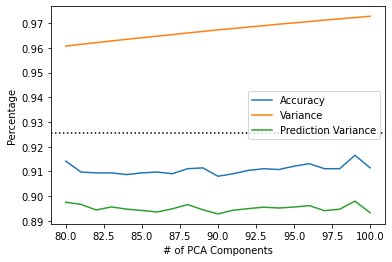

In [15]:
#output to CSV file
pca_df = pd.DataFrame(list(zip(component_list, acc_list, var_list,pred_var_list))
                      ,columns = ['Component', 'Accuracy', 'Component Variance', 'Prediction Variance'])
print(pca_df)
pd.DataFrame(pca_df).to_csv('PCA_tuning.csv')

import matplotlib.pyplot as plt
line1=plt.plot(component_list, acc_list)
line2=plt.plot(component_list, var_list)
line3=plt.plot(component_list, pred_var_list)
plt.axhline(y=0.925662, color = 'k', linestyle = ':')
plt.xlabel("# of PCA Components")
plt.ylabel("Percentage")
plt.legend((line1[0], line2[0], line3[0]), ('Accuracy', 'Variance', 'Prediction Variance'))
plt.show()

Using the following settings:

Batch size = 512
Epochs = 500
Number of dimensions = 190